In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "/Users/hamid/piibamm/PyBaMM/GM2022/data/esoh_R/"
oCV_DIR = "/Users/hamid/piibamm/PyBaMM/GM2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
# parameter_values = get_parameter_values()

parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48e-6,
        "Lower voltage cut-off [V]": 2.7,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [3]:
parameter_values.search("maximum con")

Maximum concentration in negative electrode [mol.m-3]	28746.0
Maximum concentration in positive electrode [mol.m-3]	35380.0


In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
parameter_values.update(
    {
"Electrode width [m]":0.135,
"Nominal cell capacity [A.h]":3.5,
        
# "Maximum concentration in positive electrode [mol.m-3]":37500,
       
# Updating since February 2022        
"Negative electrode porosity":0.3,
"Positive electrode thickness [m]":5.565e-05,
"Negative electrode thickness [m]": 5.5605e-05,
# "Electrode width [m]" : 0.11,      
"Negative particle radius [m]":13.5e-06,
"Positive particle radius [m]":2.1e-06,
"Maximum concentration in negative electrode [mol.m-3]":27200,
"Maximum concentration in positive electrode [mol.m-3]":33700,

    }
)


In [6]:
cell = 41

In [7]:
# fe=pd.read_csv(eSOH_DIR+"aging_param_cell_IRC_cell041.csv")
# fe

## Load eSOH Data and OCV Data

In [8]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

Temp=25
dfe.N.iloc[-1]

144

In [9]:
cycles = np.array(dfe['N'].astype('int'))
cycles

array([  0,  39,  66,  93, 144])

In [10]:
US06_GM = pd.read_csv("/Users/hamid/Drive Cycle/US06_GM622_noregen.csv", comment="#", header=None).to_numpy()
HPPC_093 = pd.read_csv("/Users/hamid/Drive Cycle/HPPC_current_cell093.csv", comment="#", header=None).to_numpy()

pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at C/2 until 4.2V", 
         "Hold at 4.2V until C/50",
         "Discharge at C/2 for 1 hour",
         "Rest for 9 min",
         
         "Charge at C/2 until 4.2V", 
         "Hold at 4.2V until C/50",
         "Discharge at C/2 for 1 hour",
         "Rest for 9 min",
         
         "Charge at C/2 until 4.2V", 
         "Hold at 4.2V until C/50",
         "Discharge at C/2 for 1 hour",
         "Rest for 9 min",
         
         "Charge at 1.6C until 4.2V", 
         "Hold at 4.2V until 1.3C",
         "Charge at C/2 until 4.2V", 
         "Hold at 4.2V until C/50",
         "Discharge at C/2 for 1 hour",
         "Rest for 9 min",
        )
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment2 = pybamm.Experiment(
    [
        ("Charge at C/2 until 4.2V", 
         "Hold at 4.2V until C/50",
        "Run US06_GM (W) until 2.7V",
         "Rest for 9 min",
        )
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
    drive_cycles={"US06_GM": US06_GM},
#     cccv_handling="ode",
)


HPPC= pybamm.Experiment(
    [
        ("Run HPPC_093 (A)")
    ] *1,
    termination="50% capacity",
    drive_cycles={"HPPC_093": HPPC_093},
#     cccv_handling="ode",
)



eps_n_data

0.765529259661426

In [11]:
# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
#         "Positive electrode LAM constant proportional term [s-1]": 9.0638e-08,#1.27152e-07
        "Positive electrode LAM constant proportional term [s-1]": 3.43e-07,
#         "Negative electrode LAM constant proportional term [s-1]": 8.7257e-08,#1.27272e-06
        "Negative electrode LAM constant proportional term [s-1]": 1.47e-07,#1.27272e-06

        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
#         "SEI kinetic rate constant [m.s-1]": 6.08e-16, #4.352126e-16, #4.196499e-16, #4.60788219e-16, 1.08494281e-16 ,
        "SEI kinetic rate constant [m.s-1]": 2.76e-16,
#         "EC diffusivity [m2.s-1]": 4.55e-20, #3.6864e-19, #4.56607447e-19,8.30909086e-19,
        "EC diffusivity [m2.s-1]": 1.75e-19,        
#         "SEI growth activation energy [J.mol-1]": 0.0740062164072284, #5997.629, #1.87422275e+04,1.58777981e+04,
        "SEI growth activation energy [J.mol-1]": 0,
#         "Lithium plating kinetic rate constant [m.s-1]": 4.543e-10,
        "Lithium plating kinetic rate constant [m.s-1]": 5.48e-10,
        
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 1.3e3,
        
    #Cathode disolution
#         "Positive electrode dissolution exchange current density": 0.0000863673282791135,
        "Positive electrode dissolution exchange current density": 0,
        
        "Negative electrode dissolution exchange current density": 0,
                
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0,
             
        
        
    },
    check_already_exists=False,
)


In [12]:
Temp

25

In [13]:
pybamm.set_logging_level("NOTICE")
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,                                                      ))
sol_long= sim_long.solve(initial_soc=1, save_at_cycles=1  )

2023-07-25 13:55:07.703 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/144 (15.829 ms elapsed) --------------------
2023-07-25 13:55:07.704 - [NOTICE] callbacks.on_step_start(182): Cycle 1/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:55:07.778 - [NOTICE] callbacks.on_step_start(182): Cycle 1/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:55:07.927 - [NOTICE] callbacks.on_step_start(182): Cycle 1/144, step 3/18: Discharge at C/2 for 1 hour
CasADi - 2023-07-25 13:55:08 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integr

2023-07-25 13:55:11.226 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 8/18: Rest for 9 min
2023-07-25 13:55:11.241 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:55:11.317 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:55:11.360 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:11.425 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 12/18: Rest for 9 min
2023-07-25 13:55:11.442 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:55:11.476 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:55:11.494 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:55:11.521 - [NOTICE] callbacks.on_step_start(182): Cycle 4/144, step 16/18: Hold at 4.

2023-07-25 13:55:14.336 - [NOTICE] callbacks.on_cycle_start(174): Cycle 8/144 (6.649 s elapsed) --------------------
2023-07-25 13:55:14.336 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:55:14.410 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:55:14.455 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:14.518 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 4/18: Rest for 9 min
2023-07-25 13:55:14.533 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:55:14.604 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:55:14.646 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:14.707 - [NOTICE] callbacks.on_step_start(182): Cycle 8/144, step 8/18: Re

2023-07-25 13:55:17.413 - [NOTICE] callbacks.on_step_start(182): Cycle 11/144, step 12/18: Rest for 9 min
2023-07-25 13:55:17.427 - [NOTICE] callbacks.on_step_start(182): Cycle 11/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:55:17.462 - [NOTICE] callbacks.on_step_start(182): Cycle 11/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:55:17.480 - [NOTICE] callbacks.on_step_start(182): Cycle 11/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:55:17.499 - [NOTICE] callbacks.on_step_start(182): Cycle 11/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:55:17.544 - [NOTICE] callbacks.on_step_start(182): Cycle 11/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:17.606 - [NOTICE] callbacks.on_step_start(182): Cycle 11/144, step 18/18: Rest for 9 min
2023-07-25 13:55:17.669 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.503 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:55:17.670 - [NOTICE] callbacks.on_cycle_start(174): Cycle 

2023-07-25 13:55:20.329 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 4/18: Rest for 9 min
2023-07-25 13:55:20.345 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:55:20.416 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:55:20.463 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:20.529 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 8/18: Rest for 9 min
2023-07-25 13:55:20.543 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:55:20.614 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:55:20.654 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:20.722 - [NOTICE] callbacks.on_step_start(182): Cycle 15/144, step 12/18: Res

2023-07-25 13:55:23.608 - [NOTICE] callbacks.on_step_start(182): Cycle 18/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:55:23.655 - [NOTICE] callbacks.on_step_start(182): Cycle 18/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:23.724 - [NOTICE] callbacks.on_step_start(182): Cycle 18/144, step 18/18: Rest for 9 min
2023-07-25 13:55:23.791 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.479 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:55:23.791 - [NOTICE] callbacks.on_cycle_start(174): Cycle 19/144 (16.104 s elapsed) --------------------
2023-07-25 13:55:23.792 - [NOTICE] callbacks.on_step_start(182): Cycle 19/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:55:23.868 - [NOTICE] callbacks.on_step_start(182): Cycle 19/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:55:23.909 - [NOTICE] callbacks.on_step_start(182): Cycle 19/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:23.973 - [NOTICE] callbacks.on_step_start(1

2023-07-25 13:55:26.715 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 8/18: Rest for 9 min
2023-07-25 13:55:26.729 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:55:26.806 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:55:26.849 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:26.910 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 12/18: Rest for 9 min
2023-07-25 13:55:26.926 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:55:26.961 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:55:26.983 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:55:27.006 - [NOTICE] callbacks.on_step_start(182): Cycle 22/144, step 16/18: H

2023-07-25 13:55:29.802 - [NOTICE] callbacks.on_cycle_start(174): Cycle 26/144 (22.115 s elapsed) --------------------
2023-07-25 13:55:29.803 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:55:29.879 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:55:29.922 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:29.986 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, step 4/18: Rest for 9 min
2023-07-25 13:55:30.002 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:55:30.083 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:55:30.124 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:30.190 - [NOTICE] callbacks.on_step_start(182): Cycle 26/144, ste

2023-07-25 13:55:33.528 - [NOTICE] callbacks.on_step_start(182): Cycle 29/144, step 12/18: Rest for 9 min
2023-07-25 13:55:33.545 - [NOTICE] callbacks.on_step_start(182): Cycle 29/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:55:33.585 - [NOTICE] callbacks.on_step_start(182): Cycle 29/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:55:33.605 - [NOTICE] callbacks.on_step_start(182): Cycle 29/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:55:33.627 - [NOTICE] callbacks.on_step_start(182): Cycle 29/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:55:33.679 - [NOTICE] callbacks.on_step_start(182): Cycle 29/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:33.758 - [NOTICE] callbacks.on_step_start(182): Cycle 29/144, step 18/18: Rest for 9 min
2023-07-25 13:55:33.839 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.441 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:55:33.840 - [NOTICE] callbacks.on_cycle_start(174): Cycle 

2023-07-25 13:55:37.103 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 4/18: Rest for 9 min
2023-07-25 13:55:37.121 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:55:37.206 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:55:37.256 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:37.329 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 8/18: Rest for 9 min
2023-07-25 13:55:37.347 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:55:37.431 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:55:37.479 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:37.555 - [NOTICE] callbacks.on_step_start(182): Cycle 33/144, step 12/18: Res

2023-07-25 13:55:40.621 - [NOTICE] callbacks.on_step_start(182): Cycle 36/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:55:40.671 - [NOTICE] callbacks.on_step_start(182): Cycle 36/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:40.742 - [NOTICE] callbacks.on_step_start(182): Cycle 36/144, step 18/18: Rest for 9 min
2023-07-25 13:55:40.822 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.416 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:55:40.823 - [NOTICE] callbacks.on_cycle_start(174): Cycle 37/144 (33.136 s elapsed) --------------------
2023-07-25 13:55:40.823 - [NOTICE] callbacks.on_step_start(182): Cycle 37/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:55:40.903 - [NOTICE] callbacks.on_step_start(182): Cycle 37/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:55:40.955 - [NOTICE] callbacks.on_step_start(182): Cycle 37/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:41.029 - [NOTICE] callbacks.on_step_start(1

2023-07-25 13:55:44.057 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 8/18: Rest for 9 min
2023-07-25 13:55:44.075 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:55:44.150 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:55:44.189 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:44.258 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 12/18: Rest for 9 min
2023-07-25 13:55:44.279 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:55:44.320 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:55:44.341 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:55:44.363 - [NOTICE] callbacks.on_step_start(182): Cycle 40/144, step 16/18: H

2023-07-25 13:55:47.430 - [NOTICE] callbacks.on_cycle_start(174): Cycle 44/144 (39.743 s elapsed) --------------------
2023-07-25 13:55:47.430 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:55:47.511 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:55:47.556 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:47.624 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, step 4/18: Rest for 9 min
2023-07-25 13:55:47.639 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:55:47.717 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:55:47.756 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:47.838 - [NOTICE] callbacks.on_step_start(182): Cycle 44/144, ste

2023-07-25 13:55:51.221 - [NOTICE] callbacks.on_step_start(182): Cycle 47/144, step 12/18: Rest for 9 min
2023-07-25 13:55:51.236 - [NOTICE] callbacks.on_step_start(182): Cycle 47/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:55:51.273 - [NOTICE] callbacks.on_step_start(182): Cycle 47/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:55:51.288 - [NOTICE] callbacks.on_step_start(182): Cycle 47/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:55:51.309 - [NOTICE] callbacks.on_step_start(182): Cycle 47/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:55:51.354 - [NOTICE] callbacks.on_step_start(182): Cycle 47/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:51.426 - [NOTICE] callbacks.on_step_start(182): Cycle 47/144, step 18/18: Rest for 9 min
2023-07-25 13:55:51.496 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.379 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:55:51.497 - [NOTICE] callbacks.on_cycle_start(174): Cycle 

2023-07-25 13:55:54.393 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 4/18: Rest for 9 min
2023-07-25 13:55:54.409 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:55:54.486 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:55:54.533 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:54.602 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 8/18: Rest for 9 min
2023-07-25 13:55:54.619 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:55:54.698 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:55:54.738 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:54.802 - [NOTICE] callbacks.on_step_start(182): Cycle 51/144, step 12/18: Res

2023-07-25 13:55:57.547 - [NOTICE] callbacks.on_step_start(182): Cycle 54/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:55:57.597 - [NOTICE] callbacks.on_step_start(182): Cycle 54/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:57.673 - [NOTICE] callbacks.on_step_start(182): Cycle 54/144, step 18/18: Rest for 9 min
2023-07-25 13:55:57.758 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.354 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:55:57.759 - [NOTICE] callbacks.on_cycle_start(174): Cycle 55/144 (50.071 s elapsed) --------------------
2023-07-25 13:55:57.759 - [NOTICE] callbacks.on_step_start(182): Cycle 55/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:55:57.849 - [NOTICE] callbacks.on_step_start(182): Cycle 55/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:55:57.895 - [NOTICE] callbacks.on_step_start(182): Cycle 55/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:55:57.979 - [NOTICE] callbacks.on_step_start(1

2023-07-25 13:56:00.845 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 8/18: Rest for 9 min
2023-07-25 13:56:00.858 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:00.932 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:56:00.976 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:01.039 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 12/18: Rest for 9 min
2023-07-25 13:56:01.056 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:01.094 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:01.110 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:01.133 - [NOTICE] callbacks.on_step_start(182): Cycle 58/144, step 16/18: H

2023-07-25 13:56:03.982 - [NOTICE] callbacks.on_cycle_start(174): Cycle 62/144 (56.294 s elapsed) --------------------
2023-07-25 13:56:03.982 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:04.067 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:04.110 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:04.178 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, step 4/18: Rest for 9 min
2023-07-25 13:56:04.191 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:04.263 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:56:04.310 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:04.379 - [NOTICE] callbacks.on_step_start(182): Cycle 62/144, ste

2023-07-25 13:56:07.475 - [NOTICE] callbacks.on_step_start(182): Cycle 65/144, step 12/18: Rest for 9 min
2023-07-25 13:56:07.493 - [NOTICE] callbacks.on_step_start(182): Cycle 65/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:07.531 - [NOTICE] callbacks.on_step_start(182): Cycle 65/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:07.546 - [NOTICE] callbacks.on_step_start(182): Cycle 65/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:07.567 - [NOTICE] callbacks.on_step_start(182): Cycle 65/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:07.615 - [NOTICE] callbacks.on_step_start(182): Cycle 65/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:07.681 - [NOTICE] callbacks.on_step_start(182): Cycle 65/144, step 18/18: Rest for 9 min
2023-07-25 13:56:07.758 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.317 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:56:07.759 - [NOTICE] callbacks.on_cycle_start(174): Cycle 

2023-07-25 13:56:10.601 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:10.669 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 4/18: Rest for 9 min
2023-07-25 13:56:10.684 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:10.762 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:56:10.806 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:10.872 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 8/18: Rest for 9 min
2023-07-25 13:56:10.888 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:10.961 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:56:11.008 - [NOTICE] callbacks.on_step_start(182): Cycle 69/144, step 11/18: Disc

2023-07-25 13:56:13.738 - [NOTICE] callbacks.on_step_start(182): Cycle 72/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:13.759 - [NOTICE] callbacks.on_step_start(182): Cycle 72/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:13.802 - [NOTICE] callbacks.on_step_start(182): Cycle 72/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:13.866 - [NOTICE] callbacks.on_step_start(182): Cycle 72/144, step 18/18: Rest for 9 min
2023-07-25 13:56:13.947 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.293 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:56:13.948 - [NOTICE] callbacks.on_cycle_start(174): Cycle 73/144 (1 minute, 6 seconds elapsed) --------------------
2023-07-25 13:56:13.948 - [NOTICE] callbacks.on_step_start(182): Cycle 73/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:14.032 - [NOTICE] callbacks.on_step_start(182): Cycle 73/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:14.079 - [NOTICE] callbacks.on_ste

2023-07-25 13:56:16.808 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:56:16.851 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:16.923 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 8/18: Rest for 9 min
2023-07-25 13:56:16.939 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:17.012 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:56:17.051 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:17.116 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 12/18: Rest for 9 min
2023-07-25 13:56:17.133 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:17.167 - [NOTICE] callbacks.on_step_start(182): Cycle 76/144, step 14/18: 

2023-07-25 13:56:20.224 - [NOTICE] callbacks.on_step_start(182): Cycle 79/144, step 18/18: Rest for 9 min
2023-07-25 13:56:20.302 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.269 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:56:20.302 - [NOTICE] callbacks.on_cycle_start(174): Cycle 80/144 (1 minute, 13 seconds elapsed) --------------------
2023-07-25 13:56:20.303 - [NOTICE] callbacks.on_step_start(182): Cycle 80/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:20.410 - [NOTICE] callbacks.on_step_start(182): Cycle 80/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:20.457 - [NOTICE] callbacks.on_step_start(182): Cycle 80/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:20.525 - [NOTICE] callbacks.on_step_start(182): Cycle 80/144, step 4/18: Rest for 9 min
2023-07-25 13:56:20.538 - [NOTICE] callbacks.on_step_start(182): Cycle 80/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:20.615 - [NOTICE] callbacks.on_step_start(182

2023-07-25 13:56:23.513 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:23.585 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:56:23.624 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:23.688 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 12/18: Rest for 9 min
2023-07-25 13:56:23.704 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:23.739 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:23.757 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:23.777 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:23.827 - [NOTICE] callbacks.on_step_start(182): Cycle 83/144, ste

2023-07-25 13:56:26.634 - [NOTICE] callbacks.on_cycle_start(174): Cycle 87/144 (1 minute, 19 seconds elapsed) --------------------
2023-07-25 13:56:26.634 - [NOTICE] callbacks.on_step_start(182): Cycle 87/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:26.716 - [NOTICE] callbacks.on_step_start(182): Cycle 87/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:26.757 - [NOTICE] callbacks.on_step_start(182): Cycle 87/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:26.822 - [NOTICE] callbacks.on_step_start(182): Cycle 87/144, step 4/18: Rest for 9 min
2023-07-25 13:56:26.837 - [NOTICE] callbacks.on_step_start(182): Cycle 87/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:26.907 - [NOTICE] callbacks.on_step_start(182): Cycle 87/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:56:26.950 - [NOTICE] callbacks.on_step_start(182): Cycle 87/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:27.359 - [NOTICE] callbacks.on_step_start(182): Cycle

2023-07-25 13:56:30.142 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:30.206 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 12/18: Rest for 9 min
2023-07-25 13:56:30.222 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:30.259 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:30.275 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:30.295 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:30.340 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:30.404 - [NOTICE] callbacks.on_step_start(182): Cycle 90/144, step 18/18: Rest for 9 min
2023-07-25 13:56:30.489 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.231 A

2023-07-25 13:56:33.217 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:33.264 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:33.329 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 4/18: Rest for 9 min
2023-07-25 13:56:33.344 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:33.415 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:56:33.456 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:33.519 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 8/18: Rest for 9 min
2023-07-25 13:56:33.534 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:33.619 - [NOTICE] callbacks.on_step_start(182): Cycle 94/144, step 10/18: Hold 

2023-07-25 13:56:36.385 - [NOTICE] callbacks.on_step_start(182): Cycle 97/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:36.400 - [NOTICE] callbacks.on_step_start(182): Cycle 97/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:36.423 - [NOTICE] callbacks.on_step_start(182): Cycle 97/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:36.463 - [NOTICE] callbacks.on_step_start(182): Cycle 97/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:36.529 - [NOTICE] callbacks.on_step_start(182): Cycle 97/144, step 18/18: Rest for 9 min
2023-07-25 13:56:36.615 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.208 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:56:36.616 - [NOTICE] callbacks.on_cycle_start(174): Cycle 98/144 (1 minute, 29 seconds elapsed) --------------------
2023-07-25 13:56:36.616 - [NOTICE] callbacks.on_step_start(182): Cycle 98/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:36.699 - [NOTICE] callbacks.on_s

2023-07-25 13:56:39.400 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:39.473 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:56:39.514 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:39.589 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 8/18: Rest for 9 min
2023-07-25 13:56:39.607 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:39.686 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:56:39.722 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:39.785 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 12/18: Rest for 9 min
2023-07-25 13:56:39.802 - [NOTICE] callbacks.on_step_start(182): Cycle 101/144, step 

2023-07-25 13:56:42.705 - [NOTICE] callbacks.on_step_start(182): Cycle 104/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:42.751 - [NOTICE] callbacks.on_step_start(182): Cycle 104/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:42.827 - [NOTICE] callbacks.on_step_start(182): Cycle 104/144, step 18/18: Rest for 9 min
2023-07-25 13:56:42.912 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.184 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:56:42.913 - [NOTICE] callbacks.on_cycle_start(174): Cycle 105/144 (1 minute, 35 seconds elapsed) --------------------
2023-07-25 13:56:42.914 - [NOTICE] callbacks.on_step_start(182): Cycle 105/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:43.009 - [NOTICE] callbacks.on_step_start(182): Cycle 105/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:43.048 - [NOTICE] callbacks.on_step_start(182): Cycle 105/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:43.134 - [NOTICE] callba

2023-07-25 13:56:45.978 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:46.041 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 8/18: Rest for 9 min
2023-07-25 13:56:46.055 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:46.126 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:56:46.167 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:46.232 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 12/18: Rest for 9 min
2023-07-25 13:56:46.247 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:46.281 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:46.299 - [NOTICE] callbacks.on_step_start(182): Cycle 108/144, st

2023-07-25 13:56:49.087 - [NOTICE] callbacks.on_step_start(182): Cycle 111/144, step 18/18: Rest for 9 min
2023-07-25 13:56:49.179 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.160 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:56:49.180 - [NOTICE] callbacks.on_cycle_start(174): Cycle 112/144 (1 minute, 41 seconds elapsed) --------------------
2023-07-25 13:56:49.181 - [NOTICE] callbacks.on_step_start(182): Cycle 112/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:49.265 - [NOTICE] callbacks.on_step_start(182): Cycle 112/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:49.302 - [NOTICE] callbacks.on_step_start(182): Cycle 112/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:49.366 - [NOTICE] callbacks.on_step_start(182): Cycle 112/144, step 4/18: Rest for 9 min
2023-07-25 13:56:49.380 - [NOTICE] callbacks.on_step_start(182): Cycle 112/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:49.452 - [NOTICE] callbacks.on_step_st

2023-07-25 13:56:52.188 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:56:52.284 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:56:52.319 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:52.383 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 12/18: Rest for 9 min
2023-07-25 13:56:52.399 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:52.435 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:52.453 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:52.472 - [NOTICE] callbacks.on_step_start(182): Cycle 115/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:52.511 - [NOTICE] callbacks.on_step_start(182): Cycle 115

2023-07-25 13:56:55.772 - [NOTICE] callbacks.on_cycle_start(174): Cycle 119/144 (1 minute, 48 seconds elapsed) --------------------
2023-07-25 13:56:55.772 - [NOTICE] callbacks.on_step_start(182): Cycle 119/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:56:55.862 - [NOTICE] callbacks.on_step_start(182): Cycle 119/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:56:55.901 - [NOTICE] callbacks.on_step_start(182): Cycle 119/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:55.966 - [NOTICE] callbacks.on_step_start(182): Cycle 119/144, step 4/18: Rest for 9 min
2023-07-25 13:56:55.980 - [NOTICE] callbacks.on_step_start(182): Cycle 119/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:56:56.073 - [NOTICE] callbacks.on_step_start(182): Cycle 119/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:56:56.111 - [NOTICE] callbacks.on_step_start(182): Cycle 119/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:56.176 - [NOTICE] callbacks.on_step_start(182

2023-07-25 13:56:58.972 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:59.040 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 12/18: Rest for 9 min
2023-07-25 13:56:59.055 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:56:59.093 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:56:59.110 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:56:59.129 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:56:59.172 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:56:59.235 - [NOTICE] callbacks.on_step_start(182): Cycle 122/144, step 18/18: Rest for 9 min
2023-07-25 13:56:59.317 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now

2023-07-25 13:57:02.027 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:57:02.064 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:02.130 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 4/18: Rest for 9 min
2023-07-25 13:57:02.143 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:57:02.218 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:57:02.253 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:02.341 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 8/18: Rest for 9 min
2023-07-25 13:57:02.356 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:57:02.433 - [NOTICE] callbacks.on_step_start(182): Cycle 126/144, step 10/

2023-07-25 13:57:05.199 - [NOTICE] callbacks.on_step_start(182): Cycle 129/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:57:05.239 - [NOTICE] callbacks.on_step_start(182): Cycle 129/144, step 14/18: Hold at 4.2V until 1.3C
2023-07-25 13:57:05.255 - [NOTICE] callbacks.on_step_start(182): Cycle 129/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:57:05.277 - [NOTICE] callbacks.on_step_start(182): Cycle 129/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:57:05.316 - [NOTICE] callbacks.on_step_start(182): Cycle 129/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:05.378 - [NOTICE] callbacks.on_step_start(182): Cycle 129/144, step 18/18: Rest for 9 min
2023-07-25 13:57:05.466 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.100 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:57:05.467 - [NOTICE] callbacks.on_cycle_start(174): Cycle 130/144 (1 minute, 58 seconds elapsed) --------------------
2023-07-25 13:57:05.467 - [NOTICE] callb

2023-07-25 13:57:08.455 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 4/18: Rest for 9 min
2023-07-25 13:57:08.471 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 5/18: Charge at C/2 until 4.2V
2023-07-25 13:57:08.549 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:57:08.587 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:08.672 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 8/18: Rest for 9 min
2023-07-25 13:57:08.687 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:57:08.759 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:57:08.795 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:08.861 - [NOTICE] callbacks.on_step_start(182): Cycle 133/144, step 1

2023-07-25 13:57:11.623 - [NOTICE] callbacks.on_step_start(182): Cycle 136/144, step 15/18: Charge at C/2 until 4.2V
2023-07-25 13:57:11.642 - [NOTICE] callbacks.on_step_start(182): Cycle 136/144, step 16/18: Hold at 4.2V until C/50
2023-07-25 13:57:11.678 - [NOTICE] callbacks.on_step_start(182): Cycle 136/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:11.742 - [NOTICE] callbacks.on_step_start(182): Cycle 136/144, step 18/18: Rest for 9 min
2023-07-25 13:57:11.836 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.076 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:57:11.837 - [NOTICE] callbacks.on_cycle_start(174): Cycle 137/144 (2 minutes, 4 seconds elapsed) --------------------
2023-07-25 13:57:11.838 - [NOTICE] callbacks.on_step_start(182): Cycle 137/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:57:11.930 - [NOTICE] callbacks.on_step_start(182): Cycle 137/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:57:11.972 - [NOTICE] callback

2023-07-25 13:57:15.028 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 6/18: Hold at 4.2V until C/50
2023-07-25 13:57:15.079 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 7/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:15.156 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 8/18: Rest for 9 min
2023-07-25 13:57:15.172 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 9/18: Charge at C/2 until 4.2V
2023-07-25 13:57:15.260 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 10/18: Hold at 4.2V until C/50
2023-07-25 13:57:15.305 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 11/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:15.386 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 12/18: Rest for 9 min
2023-07-25 13:57:15.403 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, step 13/18: Charge at 1.6C until 4.2V
2023-07-25 13:57:15.454 - [NOTICE] callbacks.on_step_start(182): Cycle 140/144, ste

2023-07-25 13:57:18.487 - [NOTICE] callbacks.on_step_start(182): Cycle 143/144, step 17/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:18.565 - [NOTICE] callbacks.on_step_start(182): Cycle 143/144, step 18/18: Rest for 9 min
2023-07-25 13:57:18.667 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.052 Ah (originally 3.538 Ah, will stop at 1.769 Ah)
2023-07-25 13:57:18.668 - [NOTICE] callbacks.on_cycle_start(174): Cycle 144/144 (2 minutes, 11 seconds elapsed) --------------------
2023-07-25 13:57:18.668 - [NOTICE] callbacks.on_step_start(182): Cycle 144/144, step 1/18: Charge at C/2 until 4.2V
2023-07-25 13:57:18.753 - [NOTICE] callbacks.on_step_start(182): Cycle 144/144, step 2/18: Hold at 4.2V until C/50
2023-07-25 13:57:18.793 - [NOTICE] callbacks.on_step_start(182): Cycle 144/144, step 3/18: Discharge at C/2 for 1 hour
2023-07-25 13:57:18.864 - [NOTICE] callbacks.on_step_start(182): Cycle 144/144, step 4/18: Rest for 9 min
2023-07-25 13:57:18.882 - [NOTICE] callbacks.on_st

In [14]:
sim_long.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",
        "Loss of capacity to SEI [A.h]",
        "Terminal voltage [V]",
        "Loss of lithium to SEI [mol]",
        "X-averaged SEI thickness [m]",
        "X-averaged SEI concentration [mol.m-3]",
        "Loss of lithium to SEI [mol]",
          "Negative electrode SEI reaction overpotential [V]",
         "X-averaged negative electrode SEI volumetric interfacial current density",
        "X-averaged negative electrode SEI interfacial current density",
        "X-averaged SEI interfacial current density [A.m-2]",
        "X-averaged outer SEI interfacial current density [A.m-2]"
#         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "Throughput capacity [A.h]"
#         "Loss of active material in positive electrode [%]",
#         "X-averaged positive electrode active material volume fraction change",
#         "Positive particle surface concentration",
#         "R-averaged positive particle concentration",
#         "Positive electrode surface potential difference",
#         "Positive electrode surface potential difference [V]"

        



        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=1201.445621090401, step=12.014456210904008),…

In [15]:
SOC_0=0
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1,drive_cycle=US06_GM)

CasADi - 2023-07-07 15:02:38 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


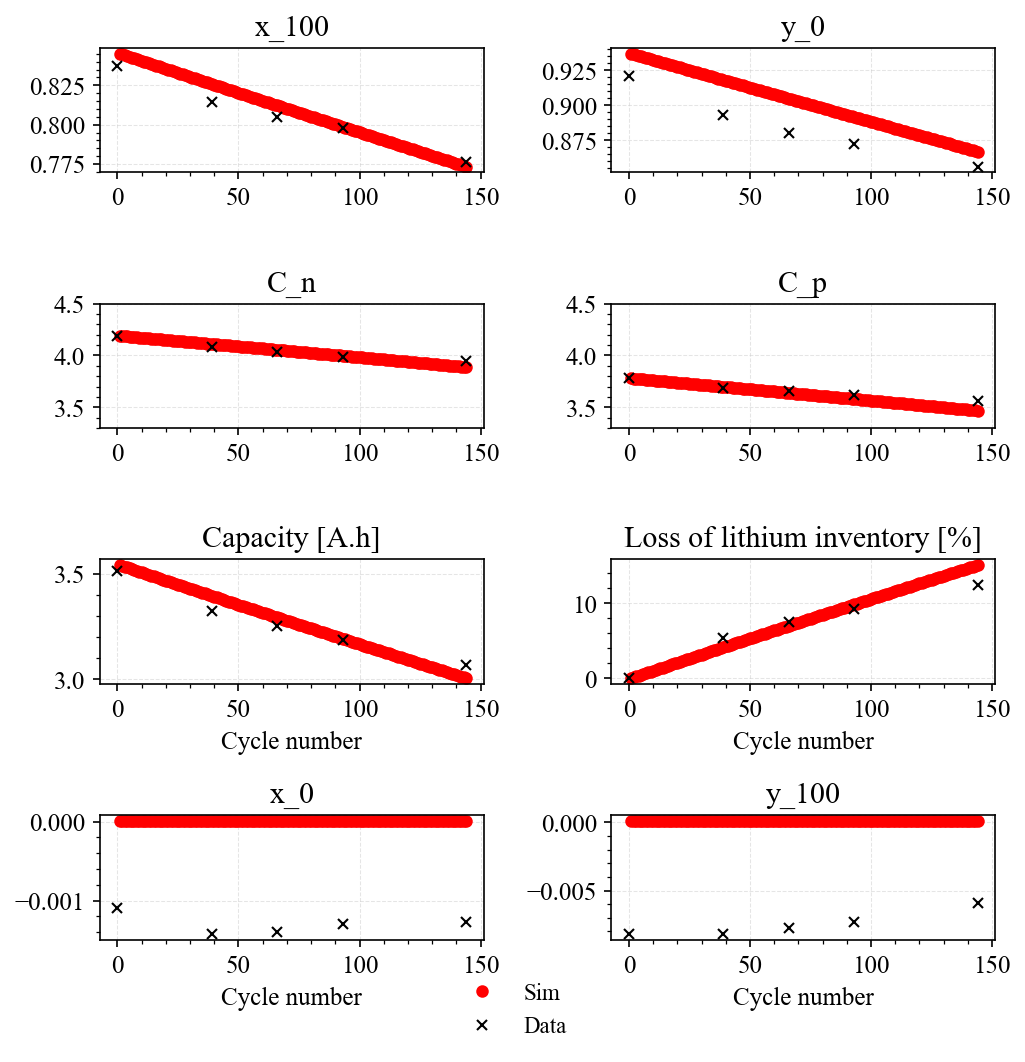

In [15]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [27]:
# dir(all_sumvars_dict)

In [13]:
# gegsg

# Parameter Fitting

## List of Initial Conditions

In [14]:
# pybamm.set_logging_level("NOTICE")


ic = 1
blam_p = [1e-6,1e-7,1e-8]
blam_n = [1e-6,1e-7,1e-8]
# k_sei= [1*2e-16,1/5*2e-16,5*2e-16]
k_pl = 1e-9
 # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]","x_100","y_0"]
    # weights = [1,1/20,5,5]

In [15]:
# pybamm.set_logging_level("NOTICE")


def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    # variables = ["C_n","C_p","x_100","y_0"]
    # weights = [1,1,5,5]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]"]
    # # weights = [1,1/20]
    variables = ["Capacity [A.h]", "Loss of lithium inventory [%]", "C_n", "C_p"]    
    weights = [1/2.5,1/10,1,1]             
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[2]*2,
            "Lithium plating kinetic rate constant [m.s-1]": x[3]*k_pl,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
        },
        check_already_exists=False,
    )
    summvvar=cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1,drive_cycle=US06_GM)
    return summvvar
def prediction_error(x):
    try:
        out=[]
        for cell in [16,41]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
            Temp=25 #Ha
            SOC_0=0 #Ha
            if cell==16:
                experiment = pybamm.Experiment(
                    [("Charge at C/2 until 4.2V", 
                         "Hold at 4.2V until C/50",
                        "Run US06_GM (W) until 2.7V",
                         "Rest for 9 min")
                    ] *dfe.N.iloc[-1],
                    termination="50% capacity",
                    drive_cycles={"US06_GM": US06_GM})
            else:
                experiment = pybamm.Experiment(
                    [("Charge at C/2 until 4.2V", 
                    "Hold at 4.2V until C/50",
                    "Discharge at C/2 for 1 hour",
                    "Rest for 9 min",
                    "Charge at C/2 until 4.2V", 
                    "Hold at 4.2V until C/50",
                    "Discharge at C/2 for 1 hour",
                    "Rest for 9 min",
                    "Charge at C/2 until 4.2V", 
                    "Hold at 4.2V until C/50",
                    "Discharge at C/2 for 1 hour",
                    "Rest for 9 min",
                    "Charge at 1.6C until 4.2V", 
                    "Hold at 4.2V until 1.3C",
                    "Charge at C/2 until 4.2V", 
                    "Hold at 4.2V until C/50",
                    "Discharge at C/2 for 1 hour",
                    "Rest for 9 min")
                    ] *dfe.N.iloc[-1],
                    termination="50% capacity")
            model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment)
            print(f"Objective")
            out_t =   multi_objective(pd.DataFrame(model), dfe)
            print(f"Concat")
            out=np.concatenate([out,out_t])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    #     except pybamm.SolverError:
    except:
        out=[]
        for cell in [16,41]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
            out_t = np.concatenate([np.array(dfe['Cap'])]*4)
            out=np.concatenate([out, out_t])
        out = 2*np.ones_like(out)
        print(f"Error")
        print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,0.8,0.51,0.4])
    # print(prediction_error(x0))
    lower = np.array([1e-3, 1e-3, 0.51, 1e-2])
    upper = np.array([1e+3, 1e+3, 2.0, 1e+2])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
#     model, out= prediction_error(x0)
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    print(timer.time())
#     solflag=soln_dfols.flag 
#     print(solflag)
    return soln_dfols
#     return model
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x

    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2],4)*2
    df['x_3'][0]=round(xsol[3],4)*k_pl
    df['obj'][0]=soln_dfols.f
#     return xsol
    return xsol ,df

In [16]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','x_3','obj'], index=[0])

In [17]:
train_len = len(N)
x12,df_x12 = sim_train(df_x)
# x12 = sim_train(df_x)
# len(N)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/dfols/solver.py:1007: RuntimeWarning: x0 below lower bound, adjusting
  warnings.warn("x0 below lower bound, adjusting", RuntimeWarning)
CasADi - 2023-07-06 23:40:42 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


Objective
Concat
Objective
Concat
x=[1.   0.8  0.51 0.4 ], norm=1.0721275262711483
Objective
Concat
Objective
Concat
x=[0.90684835 0.76479516 0.51       0.40913184], norm=1.085161684875157
Objective
Concat
Objective
Concat
x=[1.03612717 0.70753814 0.51       0.41206779], norm=1.0906034610437432
Objective
Concat
Objective
Concat
x=[1.00419502 0.81454042 0.51       0.49884826], norm=0.9595831325697991
Objective
Concat
Objective
Concat
x=[1.   0.8  0.61 0.4 ], norm=1.2558216551128019
Objective
Concat
Objective
Concat
x=[1.0136915  0.84740532 0.51       0.59281482], norm=0.8624204782920066
Objective
Concat
Objective
Concat
x=[1.22807179 1.13747014 0.51       0.76574109], norm=0.7090041462319132
Objective
Concat
Objective
Concat
x=[2.7778425  1.50063772 0.51       0.60350649], norm=0.6461689870721132
Objective
Concat
Objective
Concat
x=[3.48963209 1.47183763 0.51       0.54522639], norm=0.6390538542943193
Objective
Concat
Objective
Concat
x=[3.49500595 1.47706971 0.77050119 0.60827324], nor

In [18]:
# # dfe
# x13=pd.DataFrame(x12)
# np.array(x13.loc[dfe['N_mod']]["Capacity [A.h]"]) 

In [19]:
.fgdfdfg

SyntaxError: invalid syntax (1374486524.py, line 1)

In [18]:
df_x12

,x_0,x_1,x_2,x_3,obj
0,0.0,0.0,1.02,0.0,0.408336


In [19]:
sim_des="plating_Jason_July7"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

In [ ]:
def plotcn(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n_loss", "C_p_loss", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    all_sumvars_dict["C_n_loss"] = (all_sumvars_dict["C_n"][0]-all_sumvars_dict["C_n"])/all_sumvars_dict["C_n"][0]*100
    all_sumvars_dict["C_p_loss"] = (all_sumvars_dict["C_p"][0]-all_sumvars_dict["C_p"])/all_sumvars_dict["C_p"][0]*100
    esoh_data["C_n_loss"] = (esoh_data["C_n"][0]-esoh_data["C_n"])/esoh_data["C_n"][0]*100
    esoh_data["C_p_loss"] = (esoh_data["C_p"][0]-esoh_data["C_p"])/esoh_data["C_p"][0]*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        # if k ==2 or k==3:
        #     ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Sim"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
for cell in [152002]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    SOC_0=0
    Temp=45
    experiment = pybamm.Experiment(
        [
           ( "Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    # print(f"Model")
    sol_out = simulate(x12,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotcn(sol_out,dfe);
#     plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_'+sim_des+'.png')

In [ ]:
df_x

In [ ]:
Temp

In [ ]:
x

In [ ]:
parameter_values.search("")

In [ ]:



sim_long_Abdrew = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long_Abdrew = sim_long_Abdrew.solve(initial_soc=0, save_at_cycles=20  )


In [ ]:
pybamm.plot_summary_variables(sol_long_Abdrew)

In [15]:
# sol_long=sol_long_Abdrew
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,

In [16]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
    
       }
savemat("GMJuly_fit_DCFC_July25.mat",mdic)

In [ ]:
print(parameter_values.search("max"))
print(parameter_values.search("EC "))
print(parameter_values.search("plating"))
print(parameter_values.search("SEI"))
print(parameter_values.search("LAM"))
print(SOC_0)
print(Temp)

In [ ]:
print(eps_n_data)

In [ ]:
print(eps_p_data)

In [ ]:
parameter_values.search("")